<h1 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4); 
           color: white; 
           padding: 20px; 
           border-radius: 10px; 
           text-align: center; 
           font-family: Arial, sans-serif; 
           text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
  Multimodal Application mPersonalization and Accessibility
</h1>

<div style="background-color:#f0f8ff; padding: 15px; border-radius: 10px;">
  <br>
  <hr>

  <p>In this lab, we will explore a few ways <b>multimodal applications</b> can assist with creating content tailored for specific groups or individuals.</p>
  
  <p>Large language models (LLMs) have demonstrated remarkable capabilities in understanding and generating human-like text. By leveraging the vast knowledge encapsulated within these models, it becomes possible to generate highly personalized content tailored to individual preferences, interests, and contexts. LLMs can analyze user data to create content that resonates with each user's unique needs and preferences.</p>

  <p>Furthermore, the addition of <b>multimodal inputs</b> can significantly enhance the personalization capabilities of LLMs. Multimodal models can process and understand data in multiple modalities, such as text, images, audio, and video. By incorporating multimodal inputs, LLMs can leverage a richer set of user data, including visual preferences, audio interactions, and multimedia content consumed by the user.</p>

  <p>By leveraging multimodal inputs, LLMs can create a more comprehensive understanding of user preferences and contexts, enabling them to generate highly personalized textual content that reflects the user's diverse multimedia interactions and consumption patterns.</p>

  <p>Here is the list of topics covered in this lab:</p>
  <ol>
    <li>Installing dependencies</li>
    <li>Convert image to base64</li>
    <li>Make multimodal predictions</li>
    <li>Scene descriptions</li>
    <li>Multilingual descriptions</li>
    <li>Generate personalized and inclusive content</li>
    <li>Quizzes</li>
  </ol>

  <hr>
</div>


### Installing dependencies

In [1]:
# %%capture
# !pip install -q -r ../requirements.txt

In [2]:
import boto3
import os
import base64
import json
import requests
from tqdm import tqdm
from IPython.display import Image, display, Markdown, IFrame
import ipywidgets as widgets

### Convert image to base64

<div style="background-color:#f0f8ff; padding: 15px; border-radius: 10px; border-left: 6px solid #4682B4;">
  <p>In the context of <b>multimodal models</b> like <b>Claude3</b> models, which can process both <b>text</b> and <b>images</b>, it's important to understand that these models can only ingest images in <b>base64 format</b>. Hence, images need to be converted into this representation before they can be processed by the models.</p>

  <p><b>Base64 encoding</b> provides a way to represent binary image data as a sequence of printable ASCII characters. This encoding scheme allows you to transmit or store image data alongside other types of data, such as <b>text</b> or <b>structured data</b>, without encountering issues related to embedding binary data in text-based formats.</p>
</div>


In [3]:
def get_base64_encoded_image(image_paths):
    """
    Encode one or more image files or URLs into base64 strings.

    Args:
        image_paths (str or list): A single file path/URL or a list of file paths/URLs.

    Returns:
        tuple: A tuple containing two lists:
            - A list of base64-encoded image strings.
            - A list of corresponding image types.

    Raises:
        ValueError: If an unsupported image format is encountered.
    """
    # Convert input to list if it's a single string
    if isinstance(image_paths, str):
        image_paths = [image_paths]

    images, image_types = [], []

    # Iterate over the image paths/URLs
    for path in image_paths:
        # Check if the path is a URL
        if path.startswith("https://"):
            url_content = requests.get(path).content
            base64_encoded_data = base64.b64encode(url_content)
            base64_string = base64_encoded_data.decode('utf-8')
        # Otherwise, assume it's a file path
        else:
            with open(path, "rb") as image_file:
                binary_data = image_file.read()
                base64_encoded_data = base64.b64encode(binary_data)
                base64_string = base64_encoded_data.decode('utf-8')

        # Determine the image type based on the file extension
        path = path.lower()
        if path.endswith('.png'):
            image_type = 'image/png'
        elif path.endswith('.jpg') or path.endswith('.jpeg'):
            image_type = 'image/jpeg'
        elif path.endswith('.webp'):
            image_type = 'image/webp'
        elif path.endswith('.gif'):
            image_type = 'image/gif'
        else:
            raise ValueError("Only 'jpeg', 'png', 'webp', and 'gif' image formats are currently supported")

        images.append(base64_string)
        image_types.append(image_type)

    return images, image_types

### Make multimodal predictions

<div style="background-color:#f0f8ff; padding: 15px; border-radius: 10px; border-left: 6px solid #4682B4;">
  <p><b>Multimodal prompting</b> is a technique that allows language models to process and generate responses based on a combination of <b>text</b> and <b>image inputs</b>. The input consists of text prompts or questions along with one or more images, often encoded in <b>base64 format</b> with types specified. The language model's architecture and training allow it to understand the relationships between <b>text</b> and <b>visual information</b>.</p>

  <p>This enables more contextual and visually grounded interactions, useful for applications like <b>image captioning</b>, <b>visual question answering</b>, and <b>multimodal content generation</b>. The generated response can be textual descriptions, answers, or new multimodal outputs, leveraging both modalities for enhanced capabilities.</p>
</div>


In [4]:
def invoke_claude_3_multimodal(prompt, images, image_types):
    """
    Invoke the Claude-3 multimodal model from Anthropic using AWS Bedrock runtime.

    Args:
        prompt (str): The text prompt to provide to the model.
        images (list): A list of base64-encoded image data.
        image_types (list): A list of MIME types corresponding to the images.

    Returns:
        str: The model's response text.

    Raises:
        ValueError: If an invalid model name is provided.
    """
    # Initialize the Amazon Bedrock runtime client
    client = boto3.client(service_name="bedrock-runtime")
    model_id = "anthropic.claude-3-sonnet-20240229-v1:0"

    # Prepare the multimodal prompt message
    message_content = []

    # Add each image to the message content
    for image, img_type in zip(images, image_types):
        message_content.append({
            "type": "image",
            "source": {
                "type": "base64",
                "media_type": img_type,
                "data": image,
            },
        })
    message_content.append({"type": "text", "text": prompt})

    request_body = {
        "anthropic_version": "bedrock-2023-05-31",
        "max_tokens": 2048,
        "temperature": 0.2,
        "top_p": 1.0,
        "top_k": 250,
        "messages": [
            {
                "role": "user",
                "content": message_content,
            }
        ],
    }

    try:
        response = client.invoke_model(
            modelId=model_id,
            body=json.dumps(request_body),
        )

        # Process and return the response
        result = json.loads(response.get("body").read())
        return result['content'][0]['text']

    except ClientError as err:
        logger.error(
            "Couldn't invoke Claude 3 %s model. Here's why: %s: %s",
            model.capitalize(),
            err.response["Error"]["Code"],
            err.response["Error"]["Message"],
        )
        raise

In [5]:
def invoke_claude_3_multimodal(prompt, images, image_types):
    """
    Invoke the Claude-3 multimodal model from Anthropic using AWS Bedrock runtime.

    Args:
        prompt (str): The text prompt to provide to the model.
        images (list): A list of base64-encoded image data.
        image_types (list): A list of MIME types corresponding to the images.

    Returns:
        str: The model's response text.

    Raises:
        ValueError: If an invalid model name is provided.
    """
    # Initialize the Amazon Bedrock runtime client
    client = boto3.client(service_name="bedrock-runtime")
    model_id = "anthropic.claude-3-sonnet-20240229-v1:0"

    # Prepare the multimodal prompt message
    message_content = []

    # Add each image to the message content
    for image, img_type in zip(images, image_types):
        message_content.append({
            "type": "image",
            "source": {
                "type": "base64",
                "media_type": img_type,
                "data": image,
            },
        })
    message_content.append({"type": "text", "text": prompt})

    request_body = {
        "anthropic_version": "bedrock-2023-05-31",
        "max_tokens": 2048,
        "temperature": 0.2,
        "top_p": 1.0,
        "top_k": 250,
        "messages": [
            {
                "role": "user",
                "content": message_content,
            }
        ],
    }

    try:
        response = client.invoke_model(
            modelId=model_id,
            body=json.dumps(request_body),
        )

        # Process and return the response
        result = json.loads(response.get("body").read())
        return result['content'][0]['text']

    except ClientError as err:
        logger.error(
            "Couldn't invoke Claude 3 %s model. Here's why: %s: %s",
            model.capitalize(),
            err.response["Error"]["Code"],
            err.response["Error"]["Message"],
        )
        raise

### Scene descriptions

<div style="background-color:#f0f8ff; padding: 15px; border-radius: 10px; border-left: 6px solid #4682B4;">
  <p><b>Multimodal models</b> like <b>Claude3</b> possess remarkable capabilities in generating accurate and descriptive scene descriptions and <b>alternative text (alt text)</b> from visual inputs such as images. This powerful feature allows Claude3 to bridge the gap between visual and textual data, enabling a wide range of applications that enhance <b>accessibility</b>, <b>content moderation</b>, and <b>human-computer interaction</b>.</p>

  <p>Multimodal models can analyze the contents of an image and provide rich textual descriptions that capture the essential elements, objects, scenes, and contexts present in the visual input. This includes identifying <b>people</b>, <b>objects</b>, <b>actions</b>, <b>environments</b>, and even interpreting complex <b>diagrams</b>, <b>charts</b>, or <b>graphics</b>.</p>

  <p>In the case of generating alt text, Claude3 can produce concise yet informative descriptions that make visual content accessible to individuals with visual impairments or in situations where images cannot be displayed. These descriptions not only aid in understanding the visual content but also contribute to creating a more inclusive digital experience.</p>

  <p>In the following example, we will demonstrate how Claude3 analyzes the slides of a <b>PDF presentation</b> and generates detailed descriptions for a given slide. This practical demonstration will highlight how Claude3 can comprehend and accurately describe complex visual content, making it easier to understand, search, and share information across various platforms and applications.</p>

  <p>The following helper function extracts a specific page from a PDF document and saves it as a <b>PNG image file</b>. The extracted image can then be used as input for a multimodal model for scene description or any other image-based application.</p>
</div>


In [6]:
# Import the required library
import pypdfium2 as pdfium

# Function to extract a page from a PDF document and save it as a PNG image
def get_page(page_number, pdf_path="content/Accessibility/aws-summit.pdf"):

    # Open the PDF document
    pdf = pdfium.PdfDocument(pdf_path)

    # Get the resolution of the first page
    resolution = pdf.get_page(0).render().to_numpy().shape

    # Set the scale based on the resolution
    scale = 1 if resolution[0] >= 1620 or resolution[1] >= 1620 else 300/72

    # Get the total number of pages in the PDF document
    n_pages = len(pdf)

    # Check if the requested page number is valid
    if page_number >= n_pages:
        raise ValueError("Index is higher than max pages")

    # Get the requested page
    page = pdf.get_page(page_number)

    # Render the page as a PIL image
    pil_image = page.render(
        scale=scale,
        rotation=0,
        crop=(0, 0, 0, 0),
        may_draw_forms=False,
        fill_color=(255, 255, 255, 255),
        draw_annots=False,
        grayscale=False,
    ).to_pil()

    # Set the output file path
    output_file = os.path.join(os.path.dirname(pdf_path), "sample.png")

    # Save the rendered image as a PNG file
    pil_image.save(output_file)

    # Return the output file path
    return output_file

<div style="background-color:#f0f8ff; padding: 15px; border-radius: 10px; border-left: 6px solid #4682B4;">
  <p>Let's use the helper function defined above to extract one of the pages from a presentation.</p>

  <p>For this example, we will use a presentation from <b>AWS Summit 2024</b> on <code>Building Secure AWS Applications on AWS</code>.</p>

  <p>The selected slide describes what <b>generative AI</b> is. It shows the key properties of generative AI:</p>
  <ul>
    <li>Generating content similar to human-created content</li>
    <li>They are powered by foundation models which are pretrained on large sets of data</li>
    <li>They have many use cases such as text summarization, question answering, etc.</li>
    <li>They can be customized for specific domains with minimal effort.</li>
  </ul>

  <p>The image also shows the storyline of generative AI starting from fundamental machine learning to deep learning.</p>

  <p>Presentation PDF: <a href="https://d1.awsstatic.com/events/Summits/2024-la-summit-(amer)/SEC301_BuildingSecure_E2_LASummit_20240522.pptx.pdf">link</a></p>
</div>


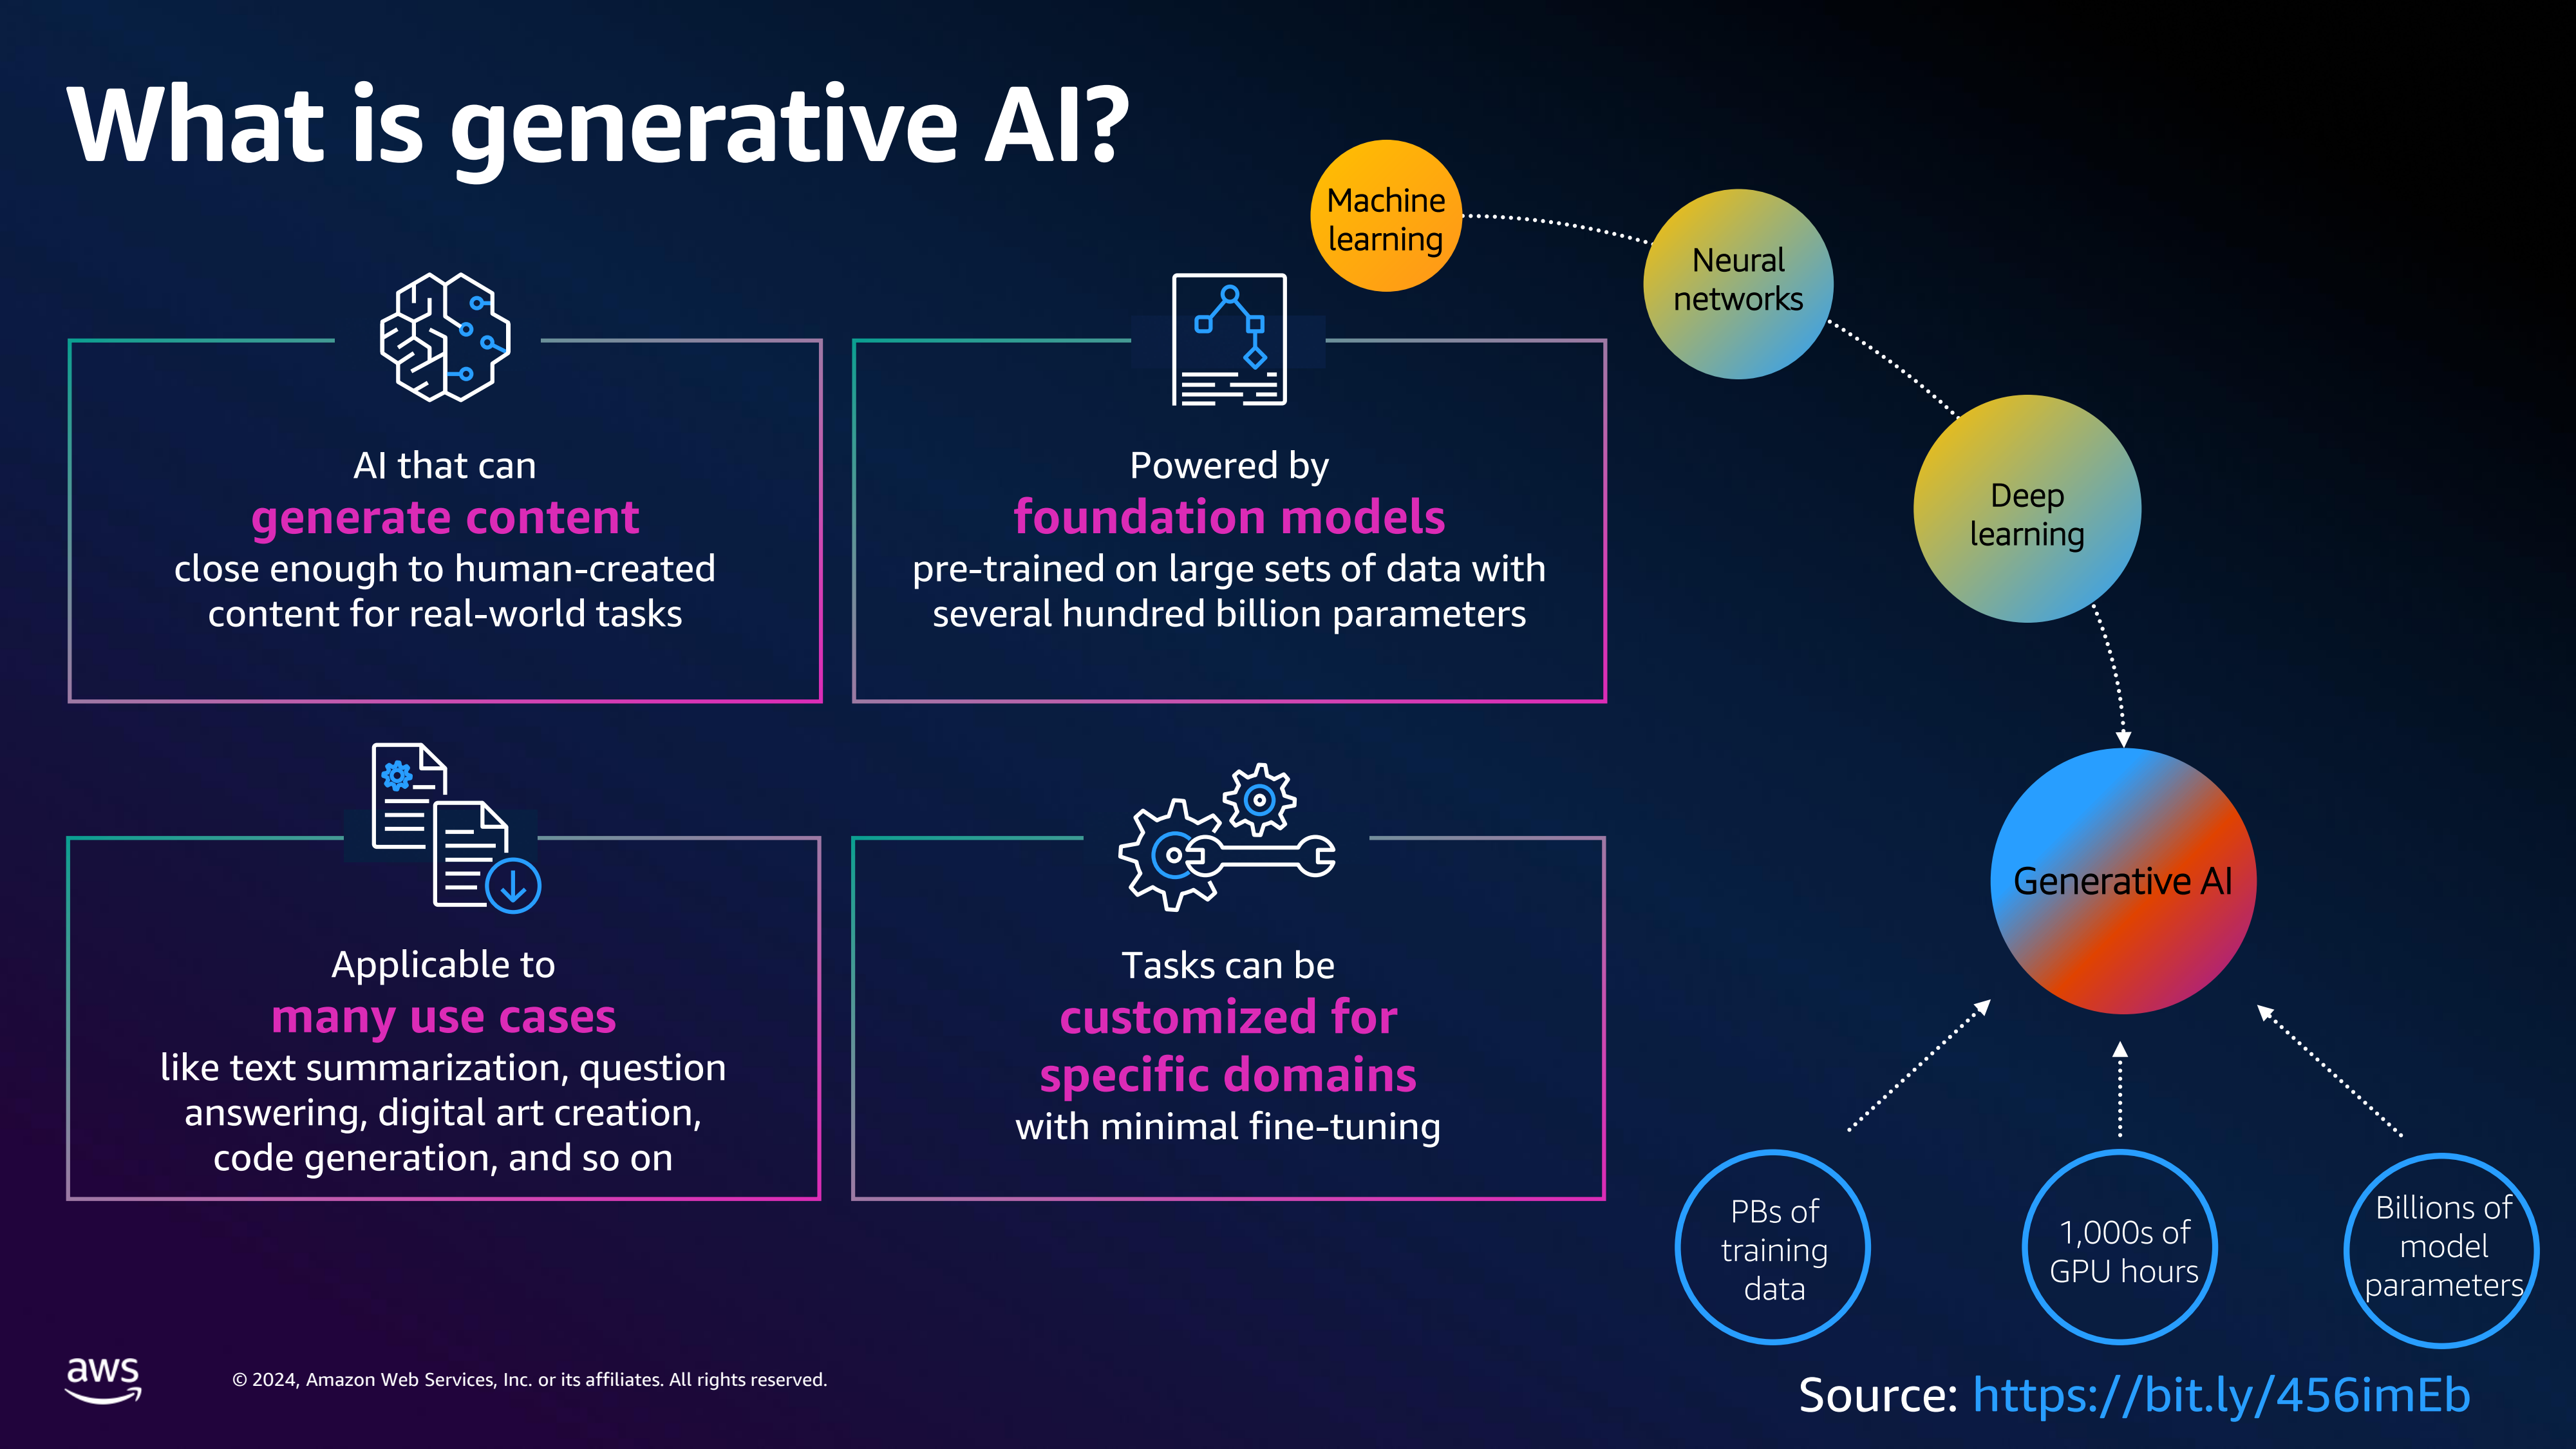

In [7]:
sample_image_path = get_page(page_number=4, pdf_path="data/aws-summit.pdf")
Image(sample_image_path)

We can now generate detailed descriptions from the image, detailing the concepts, topics, and illustrations depicted in the image. 

In [8]:
# Define the prompt for image description
description_prompt = """For the given image, write a thorough description of the concepts, topics and illustrations depicted in the image. 
Be elaborate and address all the components in the image."""

# Get base64 encoded image
image_string, image_type = get_base64_encoded_image(sample_image_path)

# Invoke Claude 3 multimodal model for image description
response = invoke_claude_3_multimodal(description_prompt, image_string, image_type)

# Display the response in Markdown format
Markdown("<i>"+response+"</i>")

<i>The image provides an overview of generative AI, which is a type of artificial intelligence that can generate content close enough to human-created content for real-world tasks. The key concepts and components illustrated in the image are as follows:

1. Definition: Generative AI is defined as AI that can generate content close enough to human-created content for real-world tasks, such as text summarization, question answering, digital art creation, code generation, and so on.

2. Foundation Models: Generative AI is powered by foundation models, which are pre-trained on large sets of data with several hundred billion parameters. These foundation models serve as the basis for various generative AI applications.

3. Machine Learning and Neural Networks: The image highlights that generative AI is built upon machine learning techniques, specifically deep learning and neural networks.

4. Customization: The image suggests that generative AI tasks can be customized for specific domains with minimal fine-tuning, allowing for tailored solutions across various industries or use cases.

5. Training Data and Computational Resources: The development of generative AI models requires massive amounts of training data (measured in petabytes), thousands of GPU hours, and billions of model parameters.

6. Applications: The image lists several potential use cases for generative AI, including text summarization, question answering, digital art creation, and code generation, among others.

The image effectively communicates the key aspects of generative AI, including its definition, underlying technologies (foundation models, machine learning, neural networks), customization capabilities, resource requirements (data and computational power), and a range of potential applications.</i>

### Multilingual Descriptions

<div style="background-color:#f0f8ff; padding: 15px; border-radius: 10px; border-left: 6px solid #4682B4;">
  <p>One of the key capabilities of <b>pre-trained models</b> is their ability to understand and process <b>multiple languages</b> simultaneously. This is a result of <b>multilingual pre-training</b>, where the model is trained on vast amounts of data from various languages, allowing it to develop a shared representation for different languages.</p>

  <p>When presented with visual content containing text or captions in multiple languages, the model can leverage its multilingual understanding to comprehend the linguistic information in those languages. Here's how it works:</p>
  <ol>
    <li>The model can recognize and extract text from the visual content, regardless of the language it is written in.</li>
    <li>The model fuses the visual information from the image or video with the linguistic information from the multilingual text or captions, creating a unified <b>multimodal representation</b>.</li>
    <li>Using this multimodal representation, the model can generate a scene description in a target language different from the languages present in the visual content. This is made possible by the model's ability to perform <b>cross-lingual transfer</b>, where it can map the multimodal representation to the desired output language.</li>
  </ol>

  <p>In the following example, the page from a presentation contains text in <b>Portuguese</b>. Claude3 can recognize and understand the text in the image, analyze the visual content, and generate a scene description in <b>English</b> (or any other supported language) that accurately captures the information from both the visual and multilingual linguistic elements.</p>

  <p>This cross-lingual scene description capability is particularly useful in scenarios where visual content needs to be described or explained in a language different from the ones present in the content itself, such as in <b>multilingual multimedia applications</b>, <b>international tourism</b>, or <b>cross-cultural communication</b>.</p>

  <p>For this example, we will use a presentation from <b>AWS Summit 2023</b>.</p>
  <p>The selected slide describes how the context of words can be represented in <b>Portuguese</b>.</p>
  <p>Presentation PDF: <a href="https://d1.awsstatic.com/events/Summits/awssaopaulo2023/DEV203_OlaMundo_E1_20230730_SPReviewed.pdf">link</a></p>
</div>


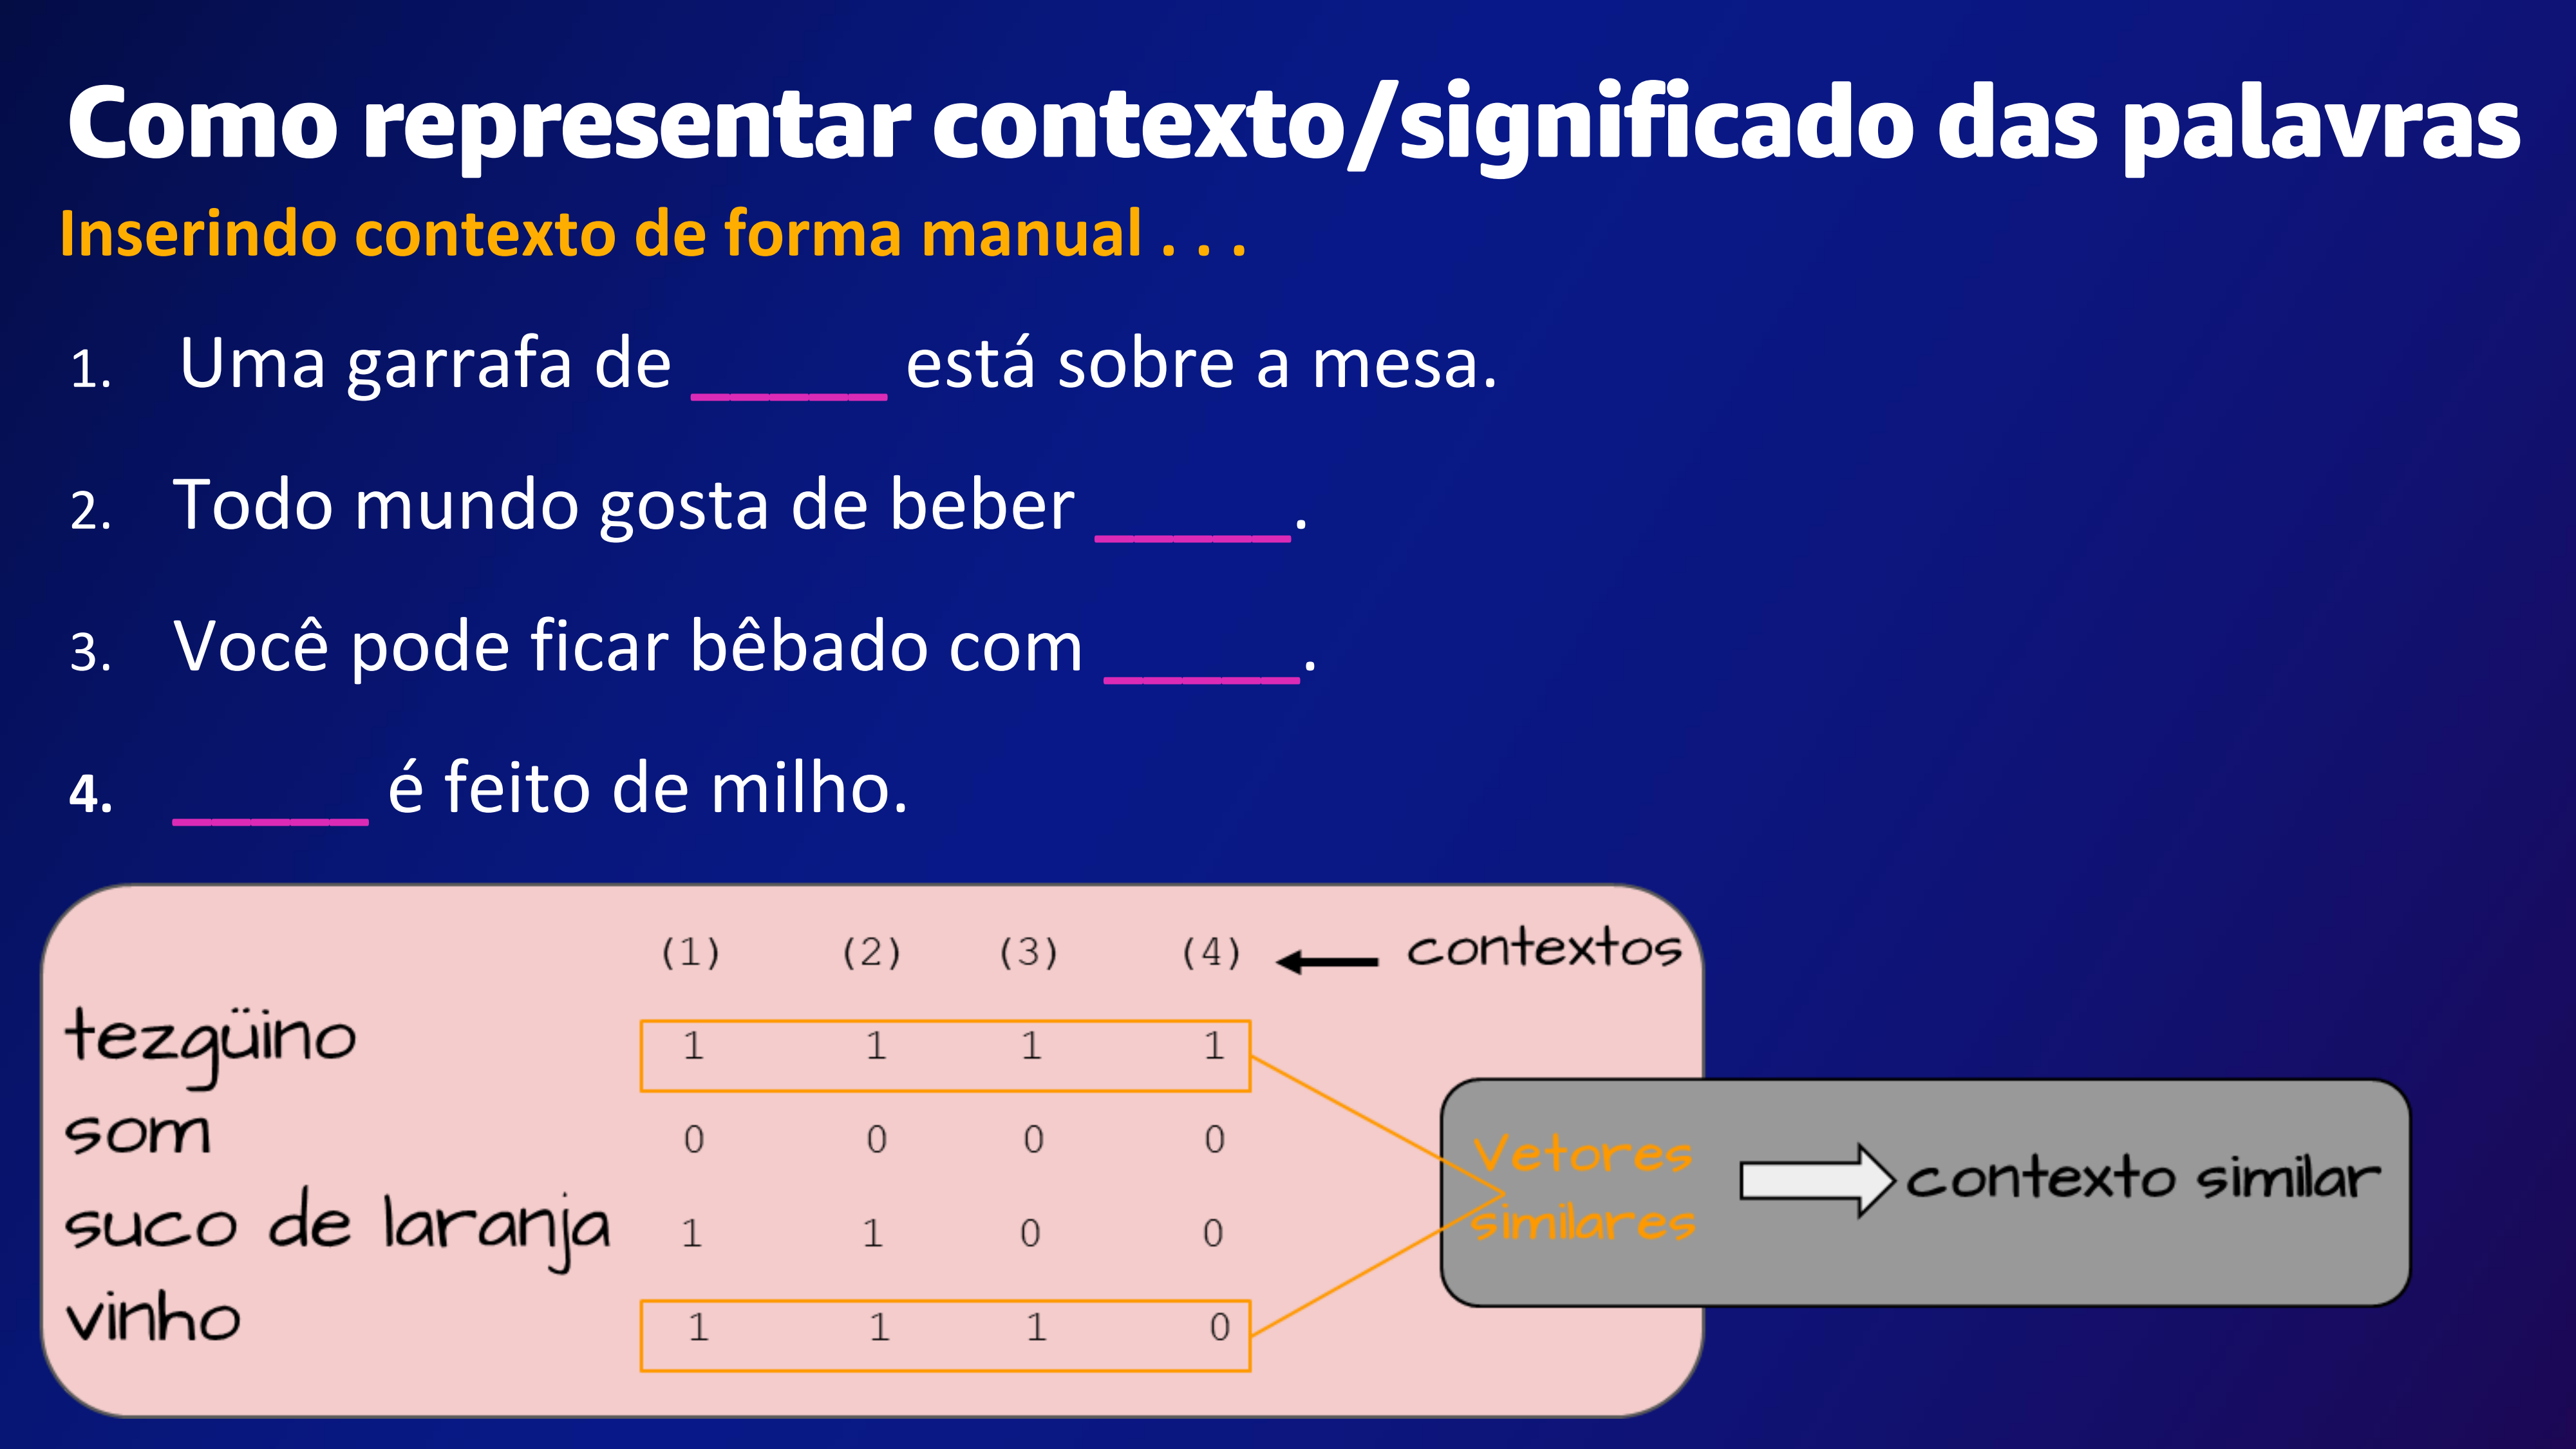

In [9]:
multilingual_image_path = get_page(page_number=25, pdf_path="data/aws-slides-portugese.pdf")
Image(multilingual_image_path)

We can now generate detailed multilingual descriptions from the image, detailing the concepts, topics and illustrations depicted in the image. 

In [10]:
# Define the prompt for multilingual image description
description_prompt = """For the given image, write a thorough description of the concepts, topics and illustrations depicted in the image in English. 
Be elaborate and address all the components in the image."""

# Get base64 encoded image
image_string, image_type = get_base64_encoded_image(multilingual_image_path)

# Invoke Claude 3 multimodal model for image description
response = invoke_claude_3_multimodal(description_prompt, image_string, image_type)

# Display the response in Markdown format
Markdown("<i>"+response+"</i>")

<i>The image presents a concept related to representing the context or meaning of words. The title at the top reads "How to represent context/meaning of words" in Portuguese.

The main part of the image demonstrates a technique for manually inserting context for words. It provides four example sentences with blanks, where the context or meaning of a word needs to be filled in.

1. "A bottle of _____ is on the table."
2. "Everyone likes to drink _____."
3. "You can get drunk with _____."
4. "_____ is made from corn."

Below these sentences, there is a table or matrix with rows labeled "tezquino," "som," "suco de laranja," and "vinho" (which means "tequino," "sound," "orange juice," and "wine" in English). The columns are numbered (1) to (4), corresponding to the four example sentences above.

The matrix contains binary values (0 or 1) in each cell, indicating whether a particular word (row) is a suitable context or meaning for the blank in the corresponding sentence (column). For instance, the word "vinho" (wine) has a 1 in columns (2) and (3), suggesting that it is a valid context for the blanks in sentences 2 and 3.

The image also includes an arrow pointing from the matrix to a box labeled "vetores similares" (similar vectors), indicating that the matrix representation can be used to find similar contexts or meanings for words.

Overall, the image illustrates a manual technique for representing the context or meaning of words using a matrix or vector representation, where each word is associated with a binary vector indicating its suitability for different contextual sentences or phrases.</i>

### Generate personalized and inclusive content

<div style="background-color:#f0f8ff; padding: 15px; border-radius: 10px; border-left: 6px solid #4682B4;">
  <p>In today's diverse and inclusive world, it's crucial to create content that resonates with a wide range of audiences. <b>Large language models (LLMs)</b> can be powerful tools in this endeavor, helping to generate inclusive, accessible, and personalized content. By following best practices and guidelines, such as those outlined by Harvard below, LLMs can assist in crafting content that is respectful, sensitive, and representative of different identities and experiences.</p>

  <p>Source: <a href="https://professional.dce.harvard.edu/blog/inclusive-language-in-4-easy-steps/">link</a></p>

  <ol>
    <li><b>Editing Assumptions and Promoting Diversity</b><br>LLMs can be adapted to recognize and mitigate biases and assumptions that may alienate or ignore diverse groups. By analyzing the context and audience, LLMs can suggest alternative phrasing or content that celebrates diversity and promotes inclusivity.</li>
    <li><b>Inclusive Pronoun Usage</b><br>LLMs can be leveraged to use gender-neutral pronouns (e.g., they/them) or to prompt users to specify preferred pronouns. This practice not only normalizes conversations about gender identities but also ensures that content is respectful and inclusive of all gender identities.</li>
    <li><b>Avoiding Ableist Language</b><br>LLMs can be trained to identify and replace ableist language, such as "crazy," "dumb," or "lame," with more descriptive and less harmful alternatives. This approach helps to eliminate stereotypes and stigma surrounding mental health conditions and physical disabilities, creating a more inclusive and respectful environment.</li>
    <li><b>Personalization and Accessibility</b><br>LLMs can be used to generate personalized content tailored to individual preferences, needs, and backgrounds. This includes adapting language, tone, and formatting to ensure accessibility for disabled persons or to meet specific requirements.</li>
  </ol>

  <p>By leveraging the power of LLMs and following inclusive language guidelines, content creators can produce material that resonates with diverse audiences, promotes inclusivity, and fosters a sense of belonging for all individuals.</p>

  <p>In the following example, we will use a few slides from a presentation given at <b>reInvent 2023</b> on <b>Prompt Engineering</b>.</p>
  <p>Presentation: <a href="https://d1.awsstatic.com/events/Summits/reinvent2023/TNC114_Introduction-to-prompt-engineering.pdf">link</a></p>
</div>


In [11]:
pdf_path = "data/aws-reinvent-slides.pdf"
IFrame(pdf_path, width="70%", height=800)

In [12]:
import pypdfium2 as pdfium
    
def pdf2imgs(pdf_path, pdf_pages_dir="data/pdf_pages"):
    """
    Convert a PDF file to individual PNG images for each page.

    Args:
        pdf_path (str): The path to the PDF file.
        pdf_pages_dir (str, optional): The directory to save the PNG images. Defaults to "content/Accessibility/pdf_pages".

    Returns:
        str: The path to the directory containing the PNG images.
    """
    
    # Open the PDF document
    pdf = pdfium.PdfDocument(pdf_path)

    # Create the directory to save the PNG images if it doesn't exist
    os.makedirs(pdf_pages_dir, exist_ok=True)

    # Get the resolution of the first page to determine the scale factor
    resolution = pdf.get_page(0).render().to_numpy().shape
    scale = 1 if max(resolution) >= 1620 else 300 / 72  # Scale factor based on resolution

    # Get the number of pages in the PDF
    n_pages = len(pdf)

    # Loop through each page and save as a PNG image
    for page_number in range(n_pages):
        page = pdf.get_page(page_number)
        pil_image = page.render(
            scale=scale,
            rotation=0,
            crop=(0, 0, 0, 0),
            may_draw_forms=False,
            fill_color=(255, 255, 255, 255),
            draw_annots=False,
            grayscale=False,
        ).to_pil()
        image_path = os.path.join(pdf_pages_dir, f"page_{page_number:03d}.png")
        pil_image.save(image_path)

    return pdf_pages_dir

Converting the PDF into individual images of pages.

In [13]:
# Convert the PDF pages to images
pdf_pages_dir = pdf2imgs(pdf_path)

Define the prompt to produce the transcript from the PDF pages. The prompt template can be adapted to include details of the demographic that you intend to appeal to with the presentation.

In [14]:
prompt = """You are an expert at producing educational content for presentations.
For the given image of a slide, write a short transcript describing the topics and the concepts detailed in the image.

You should adhere to the following instructions while generating the response:
1) The transcript should be generated for educational purposes and is presented to an audience.
2) You should never refer to the audience or the slide/image in the response.
3) Limit the response to the topics and content present in the slide. Do not create your own topics.
4) If the slide only contains headings/titles, it is likely a title slide for the upcoming content. You should only introduce the topics here without details.
5) The transcript should be inclusive and accessible to a wide audience including blind people.
6) If the slide has illustrations, explain the diagrams and illustrations in the slide to support the discussion.
7) You should not use a preamble or explain the response. Just produce the response.
8) You should use examples and analogies to describe technical concepts when appropriate.

You should tailor your response based on the following characteristics of the audience to appeal to them the most:
<Audience>
{}
</Audience>
"""

Generating transcripts for each page/slide based on the instructions in the prompt template and the personalization phrase.

In [15]:
# Set the personalization phrase
personalization_instruction = "The audience is made up of VPs of a financial institution."

# Store the transcript for each slide
transcripts = []

# Get a list of all pages
pdf_pages_list = sorted([file for file in os.listdir(pdf_pages_dir) if file.endswith(".png")])

# Generate personalized and inclusive transcripts
for page in tqdm(pdf_pages_list, desc="Generating transcripts for each slide"):
    complete_prompt = prompt.format(personalization_instruction)
    image_string, image_type = get_base64_encoded_image(os.path.join(pdf_pages_dir, page))
    response = invoke_claude_3_multimodal(complete_prompt, image_string, image_type)
    transcripts.append(response)

Generating transcripts for each slide: 100%|██████████| 8/8 [01:50<00:00, 13.87s/it]


In [16]:
# load first image
image_path = os.path.join(pdf_pages_dir, pdf_pages_list[0])
with open(image_path, 'rb') as rf:
    img = rf.read()

# Create widgets
image_widget = widgets.Image(value=img, format='png', width="100%", height=50)
text_area = widgets.Textarea(value=transcripts[0], layout=widgets.Layout(height='500px', width='100%'))
slider = widgets.IntSlider(
    value=1,
    min=1,
    max=len(pdf_pages_list),
    step=1,
    description='Slides:',
    continuous_update=True,
    layout=widgets.Layout(width='20%')
)

# Function to update image and text
def update_image_and_text(change):
    index = change.new -1
    image_path = os.path.join(pdf_pages_dir, pdf_pages_list[index])
    with open(image_path, 'rb') as rf:
        img = rf.read()
        
    image_widget.value = img
    text_area.value = transcripts[index]

# Link the slider to the update function
slider.observe(update_image_and_text, names='value')

# Display the widgets
display(widgets.VBox([
    widgets.HBox([text_area,image_widget]),
    slider
]))